<a href="https://colab.research.google.com/github/Hong-Jung1227/Machine-learning-hong/blob/main/%EC%9C%84%EC%84%B1%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%9D%B4%EB%AF%B8%EC%A7%80%ED%95%99%EC%8A%B5_Modified_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/datalab/drive")
import sys, os
sys.path.append(os.pardir)
sys.path.append("/datalab/drive/MyDrive/원격탐사_도시데이터")
my_path = "/datalab/drive/MyDrive/원격탐사_도시데이터/"

Drive already mounted at /datalab/drive; to attempt to forcibly remount, call drive.mount("/datalab/drive", force_remount=True).


In [ ]:
import pickle

with open(my_path+"Car_Segmentation/CARdata.pkl","rb") as f:
  our_images=pickle.load(f)
with open(my_path+"Car_Segmentation/CARlabel.pkl","rb") as f:
  our_labels=pickle.load(f)

print(our_images.shape)
print(our_labels.shape)

(158, 256, 256, 3)
(158, 256, 256)


In [ ]:
#훈련데이터는 80%, 테스트데이터는 20%
Ntrain = int(our_images.shape[0]*0.8)
Ntest = our_images.shape[0] - Ntrain

x_train = our_images[:Ntrain]
t_train = our_labels[:Ntrain]
x_test = our_images[Ntrain:]
t_test = our_labels[Ntrain:]

print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(126, 256, 256, 3)
(126, 256, 256)
(32, 256, 256, 3)
(32, 256, 256)


In [ ]:
# 데이터 확장
import numpy as np
import skimage.transform as transform

x_train2 = np.zeros((x_train.shape[0]*6,256,256,3))
t_train2 = np.zeros((t_train.shape[0]*6,256,256))

for i in range(x_train.shape[0]):
  x_train2[6*i] = x_train[i]
  x_train2[6*i+1] = transform.rotate(x_train[i], angle = 90, resize=False)
  x_train2[6*i+2] = transform.rotate(x_train[i], angle = 180, resize=False)
  x_train2[6*i+3] = transform.rotate(x_train[i], angle = 270, resize=False)
  x_train2[6*i+4] = x_train[i,::-1,:]
  x_train2[6*i+5] = x_train[i,:,::-1]

  t_train2[6*i] = t_train[i]
  t_train2[6*i+1] = transform.rotate(t_train[i], angle = 90, resize=False)
  t_train2[6*i+2] = transform.rotate(t_train[i], angle = 180, resize=False)
  t_train2[6*i+3] = transform.rotate(t_train[i], angle = 270, resize=False)
  t_train2[6*i+4] = t_train[i,::-1,:]
  t_train2[6*i+5] = t_train[i,:,::-1]

x_test2 = np.zeros((x_test.shape[0]*6,256,256,3))
t_test2 = np.zeros((t_test.shape[0]*6,256,256))

for i in range(x_test.shape[0]):
  x_test2[6*i] = x_test[i]
  x_test2[6*i+1] = transform.rotate(x_test[i], angle = 90, resize=False)
  x_test2[6*i+2] = transform.rotate(x_test[i], angle = 180, resize=False)
  x_test2[6*i+3] = transform.rotate(x_test[i], angle = 270, resize=False)
  x_test2[6*i+4] = x_test[i,::-1,:]
  x_test2[6*i+5] = x_test[i,:,::-1]

  t_test2[6*i] = t_test[i]
  t_test2[6*i+1] = transform.rotate(t_test[i], angle = 90, resize=False)
  t_test2[6*i+2] = transform.rotate(t_test[i], angle = 180, resize=False)
  t_test2[6*i+3] = transform.rotate(t_test[i], angle = 270, resize=False)
  t_test2[6*i+4] = t_test[i,::-1,:]
  t_test2[6*i+5] = t_test[i,:,::-1]



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Activation, Flatten, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

In [ ]:
def Encoder(x, filters=64):
  
  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  pool = MaxPooling2D(pool_size=(2,2))(x)

  return x, pool

def Decoder(x, _c = None, filters=64):

  if _c != None:
    x = concatenate([x, _c], axis=-1)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = UpSampling2D(size=(2,2))(x)

  return x

def Outblock(x, _c = None, filters=64):

  if _c != None:
    x = concatenate([x, _c], axis=-1)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Dropout(0.3)(x)

  x = Conv2D(filters, (3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(16,(3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(2,(3,3), kernel_initializer='he_normal',padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation('softmax')(x)

  return x

def UnetSegmentation(input_size=(256,256,3)):

  in1 = Input(shape=input_size)

  inc1,pool1 = Encoder(in1, 64)       # 256, 128
  inc2,pool2 = Encoder(pool1, 128)    # 128, 64
  inc3,pool3 = Encoder(pool2, 256)    # 64, 32
  inc4,pool4 = Encoder(pool3, 512)    # 32, 16

  x = Decoder(pool4,None,1024)        #32
  x = Decoder(x, inc4,512)            #64
  x = Decoder(x, inc3,256)            #128
  x = Decoder(x, inc2,128)            #256

  x = Outblock(x,inc1,64)      #256

  model = Model(inputs=[in1], outputs=[x])

  return model

  
  

In [ ]:
# 모델컴파일
lr = 0.001
mini_batch = 5
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["gpu:0"])
with mirrored_strategy.scope():
  model = UnetSegmentation()
  model.compile(optimizer=Adam(learning_rate=lr),loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_29 (Conv2D)             (None, 256, 256, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_29 (BatchN  (None, 256, 256, 64  256        ['conv2d_29[0][0]']              
 ormalization)                  )                                                           

In [ ]:
mcp_save = keras.callbacks.ModelCheckpoint(my_path+"cnn_param.h5",save_best_only=True,monitor="val_accuracy",mode="max")

hist = model.fit(x_train2,t_train2,batch_size=mini_batch,validation_data=(x_test2,t_test2),epochs=20,callbacks=[mcp_save])

Epoch 1/20
152/152 [==============================] - 107s 657ms/step - loss: 0.5870 - accuracy: 0.8925 - val_loss: 817.3737 - val_accuracy: 0.0563
Epoch 2/20
152/152 [==============================] - 97s 641ms/step - loss: 0.4482 - accuracy: 0.9427 - val_loss: 0.3221 - val_accuracy: 0.9318
Epoch 3/20
152/152 [==============================] - 97s 641ms/step - loss: 0.3626 - accuracy: 0.9532 - val_loss: 0.3374 - val_accuracy: 0.9504
Epoch 4/20
152/152 [==============================] - 97s 641ms/step - loss: 0.2977 - accuracy: 0.9595 - val_loss: 0.2945 - val_accuracy: 0.9581
Epoch 5/20
152/152 [==============================] - 97s 641ms/step - loss: 0.2537 - accuracy: 0.9619 - val_loss: 0.2317 - val_accuracy: 0.9686
Epoch 6/20
152/152 [==============================] - 91s 602ms/step - loss: 0.2156 - accuracy: 0.9654 - val_loss: 0.2819 - val_accuracy: 0.9496
Epoch 7/20
152/152 [==============================] - 98s 643ms/step - loss: 0.1894 - accuracy: 0.9674 - val_loss: 0.1565 - val

In [ ]:
pred_val=np.zeros_like(t_test2)
for i in range(x_test2.shape[0]//mini_batch+1):
    pred_val[mini_batch*i:mini_batch*(i+1)]=np.argmax(model.predict(x_test2[mini_batch*i:mini_batch*(i+1)]),axis=3)

1/1 [==============================] - 0s 64ms/step


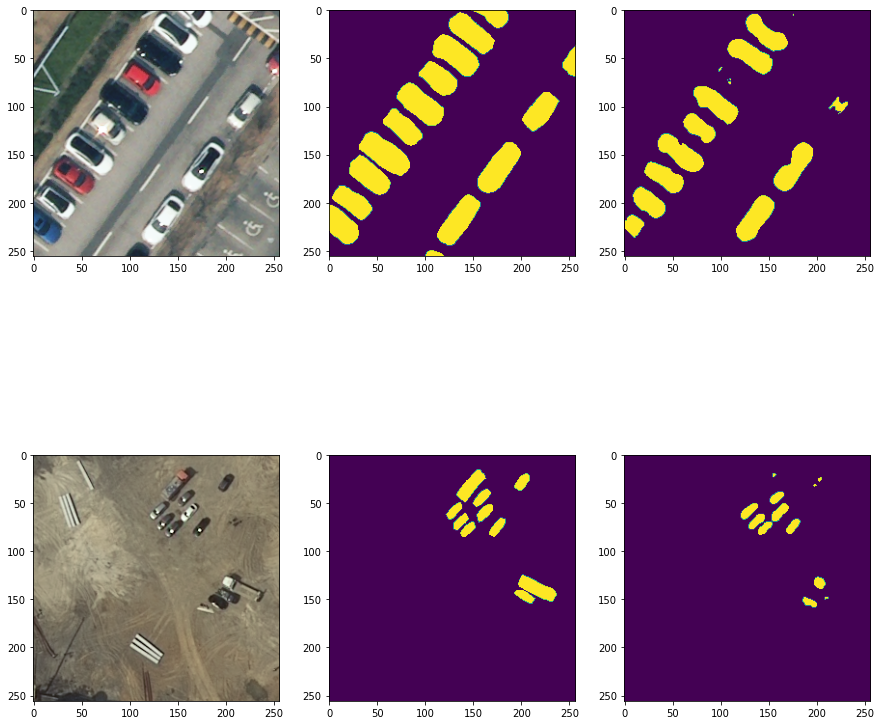

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.subplot(2,3,1)
plt.imshow(x_test2[5])
plt.subplot(2,3,2)
plt.imshow(t_test2[5])
plt.subplot(2,3,3)
plt.imshow(pred_val[5])

plt.subplot(2,3,4)
plt.imshow(x_test2[21])
plt.subplot(2,3,5)
plt.imshow(t_test2[21])
plt.subplot(2,3,6)
plt.imshow(pred_val[21])